# Figure 5 Master Document

This is the master document for figure 5, which includes all code that will be frozen before receiving the new set of coregistrated cells. All frozen code is directly tasked at testing Hebb's hypotheses of assembly synaptic organization.

Code to Freeze:
Sanity checks: Outbound from a single cell: Shared n=41, disjoint=43, shared_no_a=12, a_no_a=43, no_a_a=12
 
For all c functions (shared, disjoint, shared_no_a, etc.)
1. Monosynaptic Pairs - Chi Squared binary connectivity
    1. Status: Implemented by Stefan and Trevor, need to validate
2. Monosynaptic Pairs - ranksum of summed PSD volume
    1. Status: Implemented by Stefan and Trevor and Sai, need to validate
3. Per-cell outbound and inbound - ranksum probability of connection
    1. Status: Implemented by Stefan and Trevor and Sai, need to validate
4. Per-cell nonzero outbound and inbound - pairwise signed rank of summed PSD volumes
    1. Status: Implemented by Julian and Sai, need to validate
5. Per-cell nonzero outbound and inbound - unpaired ranksum of summed PSD volumes
    1. Status: Implemented by Stefan and Julian, need to validate
6. Betweenness centrality
    1. Status: Implemented for pyr and all, validated, needs cleaning review
    2. Julian will do cleaning review and addition to master document
7. In-degree centrality
    1. Status: Implemented for pyr and all, validated, needs cleaning review
    2. Julian will do cleaning review and addition to master document
8. Out-degree centrality
    1. Status: Implemented for pyr and all, validated, needs cleaning review
    2. Julian will do cleaning review and addition to master document
9. 1-5 by multisynaptic chain
    1. Partially(?) implemented by Julian, partially implemented by Stefan
10. 1-5 for multisynaptic chain with middle interneuron

For exploration later: 
1. ANOVA
2. centrality of subgraphs (shared, disjoint, etc)
3. comparison of Assembly vs No A (not specifying the post-synaptic partner)


In [1]:
# importing packages
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import json
from tqdm import tqdm
from scipy import stats
import seaborn as sns
import networkx as nx
import pickle
from dotmotif import Motif, GrandIsoExecutor
plt.rcParams.update({'font.size': 20})
plt.rcParams["figure.figsize"] = (10,10)
sns.set_theme(style="whitegrid")
random.seed(747)

# Import Stefan's Library for Data Management of V1DD
from lsmm_data import LSMMData

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [ ]:
# Set-Wise Comparison Functions: Determining the intersection of assembly assignment of two pyramidal cells 
# These comparison functions map to C in the statistical methods section.
def shared(pre, post, A):
    try:
        return not A[pre].isdisjoint(A[post])
    except KeyError:
        return False

def disjoint(pre, post, A):
    try:
        return A[pre].isdisjoint(A[post])
    except KeyError:
        return False

def shared_no_a(pre, post, A):
    return (pre in no_A) and (post in no_A) # type: ignore
    
def no_a_a(pre, post, A):
    return (pre in no_A) and (post not in no_A) # type: ignore

def a_no_a(pre, post, A):
    return (pre not in no_A) and (post in no_A) # type: ignore

comparison_functions = [shared, disjoint, shared_no_a, no_a_a, a_no_a]

## Monosynaptic Analysis on Pyramidal Cell Rectangular Connectome

In [3]:
results_folder = "pyr_only_rectangular_results"

In [4]:
def plot_monosynpatic_comparisons(comparison_dict: dict,
                                    directionality: str,
                                    binary_counts = False,
                                    syn_counts = False, 
                                    summed_psd = False,
                                    non_zero = False,
                                    by_connection = False,
                                    save_fig = False):
    
    x_labels_by_func = {"shared": "Shared Assembly Membership", 
                        "disjoint": "Disjoint Assembly Membership", 
                        "shared_no_a": "Shared No Assembly", 
                        "no_a_a": "No Assembly to Assembly", 
                        "a_no_a": "Assembly to No Assembly"}

    if binary_counts and syn_counts:
        raise ValueError("Must either be working with binary or synaptic count connectome.")
    if (binary_counts or syn_counts) and summed_psd:
        raise ValueError("Must either be working with PSD or connectivity.")

    # Based on the connectome flags, save it in the right folder, set the correct y_label and plot title
    if binary_counts:
        connectome_desc = "Binary"
        folder = "binary_connectome"
        suffix = f"{directionality} Binary Connectivity with Pyramidal Cells"
        y_lab = "Binary Connections"
    elif summed_psd:
        connectome_desc = "Summed_PSD"
        folder = "summed_size_connectome"
        suffix = f"{directionality} Post Syanptic Strength with Pyramidal Cells"
        y_lab = "Summed Synaptic Strength (PSD in nm$^3$)"
    elif syn_counts:
        connectome_desc = "Syn_Counts"
        folder = "synapse_count_connectome"
        suffix = f"{directionality} First-Order Connectivity with Pyramidal Cells"
        y_lab = "Synaptic Counts"
    else:
        raise ValueError("Must specify which connectome is being used.")
    

    prefix = "Paired Cell Involvement" if by_connection else "Cell Involvement"
    prefix = "Non-Zero " + prefix if non_zero else prefix

    for c1 in comparison_functions:
        for c2 in comparison_functions:
            if c1.__name__ != c2.__name__:
                print(f'\n{c1.__name__} vs {c2.__name__}')
                if non_zero:
                    c1_set = np.array(list(comparison_dict[c1.__name__].values()))[np.array(list(comparison_dict[c1.__name__].values())).nonzero()[0]]
                    c2_set = np.array(list(comparison_dict[c2.__name__].values()))[np.array(list(comparison_dict[c2.__name__].values())).nonzero()[0]]
                else:
                    c1_set = np.array(list(comparison_dict[c1.__name__].values()))
                    c2_set = np.array(list(comparison_dict[c2.__name__].values()))
                result = stats.ranksums(c1_set, c2_set, alternative='greater')
                if result.pvalue < 0.05:
                    print('Greater:')
                    print(result)
                    
                    # Create a figure with specific size
                    _, ax = plt.subplots(figsize=(10, 6))  # Width = 12 inches, Height = 6 inches
                    sns.set_theme(style="whitegrid")

                    # Create the violin plot
                    sns.violinplot(data=[c1_set, c2_set],
                                inner='box',  # Show quartiles and median (similar to boxplot)
                                linewidth=1.5,
                                split=False,  # Not splitting, as we're comparing two distributions
                                palette=["grey", "cyan"],  # Use the same palette as before
                                ax=ax
                                )
                    
                    # Overlay a stripplot to show individual points, including outliers
                    sns.swarmplot(data=[c1_set, c2_set],
                                color='white',  # Use black color to differentiate points
                                edgecolor= 'grey',
                                size = 3,
                                ax=ax
                                )
                    
                    # Calculate and add the median line
                    medians = [np.median(c1_set), np.median(c2_set)]
                    for i, median in enumerate(medians):
                        ax.plot([i - 0.2, i + 0.2], [median, median], color='red', linestyle='-', linewidth=2, label="Median" if i == 0 else "")

                    # Set the x-axis labels
                    x_ticks = [x_labels_by_func[c1.__name__], x_labels_by_func[c2.__name__]]
                    ax.set_xticklabels(x_ticks, size=12)

                    # Set a multiline title to include the p-value, add y_label
                    ax.set_title(f'{prefix}: {suffix}\nWilcoxon Rank-Sum P-value: {result.pvalue:.4f}', size=16)
                    ax.set_ylabel(y_lab, size=12)

                    # sns.set_theme(style="whitegrid")
                    # sns.boxplot(data=[c1_set, c2_set],
                    #                 notch= False, showcaps=True,
                    #                 flierprops={"marker": "x"},
                    #                 medianprops={"color": "red"}, #coral
                    #                 palette= ["grey", "cyan"],
                    #                 ax = ax
                    #             )
                    # x_ticks = [c1.__name__, c2.__name__]
                    # ax.set_xticklabels(x_ticks, size = 12)
                    # ax.set_title(f'{prefix}: {suffix}', size = 16)
                    # ax.set_ylabel(y_lab, size = 12)
                    # plt.xticks(rotation=45)
                    # plt.figure()
                    # # plt.boxplot([list(comparison_dict[c1.__name__].values()), list(comparison_dict[c2.__name__].values())])
                    # # plt.title(f'SUMMED OUTBOUND BINARY: {c1.__name__} vs {c2.__name__}')
                    
                    fig_title = f"{connectome_desc}_Grouped_Assemblies_Boxplot.png"
    
                    if save_fig:
                        plt.savefig(f'{results_folder}/{folder}/{fig_title}', dpi = 1200)
                    plt.tight_layout()
                    plt.show()


### Prepare Sets

In [5]:
with open('pyr_cells_rectangular_connectome.json') as f:
    lsmm_json_input = json.load(f)
v1dd_data = LSMMData.LSMMData(lsmm_json_input)

data_a = v1dd_data.data
params_a = v1dd_data.params
dirs_a = v1dd_data.dirs
mappings_a = v1dd_data.mappings

Filtering to pyramidal cells only
459


/Users/jawagnercarena/opt/anaconda3/envs/assembly/lib/python3.10/site-packages/lsmm_data/LSMMData.py:391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['structural']['post_cell']['connectome_index'] = data['structural']['post_cell'].index
/Users/jawagnercarena/opt/anaconda3/envs/assembly/lib/python3.10/site-packages/lsmm_data/LSMMData.py:417: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['structural']['post_cell']['pt_position'] = [[data['structural']['post_cell'].iloc[i]['pt_position_x'],data['st

Generating Connectome...


100%|██████████| 44293/44293 [00:09<00:00, 4816.45it/s]


Generating Connectome...


100%|██████████| 44293/44293 [00:10<00:00, 4352.03it/s]


In [6]:
### Pull necessary data from V1DD using LSMMData Manager
cell_table = data_a['structural']['pre_cell'].copy()
cell_table['connectome_index'] = cell_table.index
post_cell_table = data_a['structural']['post_cell'].copy()
post_cell_table['connectome_index'] = post_cell_table.index
synapse_table = data_a['structural']['synapse']

# Establish seperate sets for the pre and post synaptic partnes
# This is necessary as the set of connectome index of pre-synaptic cells do not 
# match the post-synaptic cells due to allowing unproofread post-synaptic targets.
individual_assembly_indexes = [mappings_a['connectome_indexes_by_assembly'][f'A {i}'] for i in range(1,16)]
individual_post_assembly_indexes = [mappings_a['post_connectome_indexes_by_assembly'][f'A {i}'] for i in range(1,16)]

coregistered_post_cell_indexes = mappings_a['assemblies_by_post_connectome_index'].keys()
coregistered_cell_indexes = mappings_a['assemblies_by_connectome_index'].keys()

no_a_cell_indexes = mappings_a['connectome_indexes_by_assembly']['No A']
no_a_post_cell_indexes = mappings_a['post_connectome_indexes_by_assembly']['No A']

pooled_assembly_indexes = list(set(coregistered_cell_indexes) - set(no_a_cell_indexes))
pooled_assembly_post_indexes = list(set(coregistered_post_cell_indexes) - set(no_a_post_cell_indexes))

# Each cell has a distinct root id, so it is unnecessary to establish different sets
assembly_to_root_ids = mappings_a['pt_root_ids_by_assembly']
assembly_root_ids_set = set(mappings_a['assemblies_by_pt_root_id'].keys())

# Filter synapses_table to only synapses between two assembly cells (including No A)
synapses_df = synapse_table[synapse_table['pre_pt_root_id'].isin(assembly_root_ids_set)]
synapses_df = synapses_df[synapses_df['post_pt_root_id'].isin(assembly_root_ids_set)]

# Filter cell tables to only assembly cells
cell_table = cell_table[cell_table['pt_root_id'].isin(assembly_root_ids_set)]
post_cell_table = post_cell_table[post_cell_table['pt_root_id'].isin(assembly_root_ids_set)]

# Finalized set of Root IDs, which are 
pre_root_ids = set(cell_table['pt_root_id'].values)
post_root_ids = set(post_cell_table['pt_root_id'].values)
all_root_ids = pre_root_ids | post_root_ids

In [7]:
### Prep the sets for Analysis, following our description in the Methods section
# Collect our connectomes of pre and post synaptic sets based on the root_ids of the neurons
w = {}
s = {}
b = {}
for pre in pre_root_ids:
    for post in post_root_ids:
        w[(pre, post)] = 0
        s[(pre, post)] = 0
        b[(pre, post)] = 0

for i, row in synapses_df.iterrows():
    pre = row['pre_pt_root_id']
    post = row['post_pt_root_id']
    w[(pre, post)] += row['size']
    s[(pre, post)] += 1
    b[(pre, post)] = 1

# Split out assemblies and no_a
assembly_names = set(assembly_to_root_ids.keys()) - set(['No A'])
A_invert = {assembly: set(assembly_to_root_ids[assembly]) for assembly in assembly_names}
no_A = set(assembly_to_root_ids['No A'])
all_coregistered_root_ids = mappings_a['assemblies_by_pt_root_id'].keys()
assembly_root_ids_excluding_no_A = set(all_coregistered_root_ids) - no_A
A = {pt_root_id: set(mappings_a['assemblies_by_pt_root_id'][pt_root_id]) for pt_root_id in all_root_ids if 'No A' not in mappings_a['assemblies_by_pt_root_id'][pt_root_id]}

In [8]:
# Calculate the weighted summed values, including normalized values

backup_pre_root_ids = pre_root_ids
backup_post_root_ids = post_root_ids

W_out = {}
for c in comparison_functions:
    W_out[c.__name__] = {}
    for j in pre_root_ids:
        post_root_ids = backup_post_root_ids - set([j])
        if len([i for i in post_root_ids if c(j, i, A)]) > 0:
            W_out[c.__name__][j] = sum([w[(j, i)] for i in post_root_ids if c(j, i, A)]) / len([i for i in post_root_ids if c(j, i, A)])
    
W_in = {}
for c in comparison_functions:
    W_in[c.__name__] = {}
    for i in post_root_ids:
        pre_root_ids = backup_pre_root_ids - set([i])
        if len([j for j in pre_root_ids if c(j, i, A)]) > 0:
            W_in[c.__name__][i] = sum([w[(j, i)] for j in pre_root_ids if c(j, i, A)]) / len([j for j in pre_root_ids if c(j, i, A)])

S_out = {}
for c in comparison_functions:
    S_out[c.__name__] = {}
    for j in pre_root_ids:
        post_root_ids = backup_post_root_ids - set([j])
        if len([i for i in post_root_ids if c(j, i, A)]) > 0:
            S_out[c.__name__][j] = sum([s[(j, i)] for i in post_root_ids if c(j, i, A)]) / len([i for i in post_root_ids if c(j, i, A)])

S_in = {}
for c in comparison_functions:
    S_in[c.__name__] = {}
    for i in post_root_ids:
        pre_root_ids = backup_pre_root_ids - set([i])
        if len([j for j in pre_root_ids if c(j, i, A)]) > 0:
            S_in[c.__name__][i] = sum([s[(j, i)] for j in pre_root_ids if c(j, i, A)]) / len([j for j in pre_root_ids if c(j, i, A)])

B_out = {}
for c in comparison_functions:
    B_out[c.__name__] = {}
    for j in pre_root_ids:
        post_root_ids = backup_post_root_ids - set([j])
        if len([i for i in post_root_ids if c(j, i, A)]) > 0:
            B_out[c.__name__][j] = sum([b[(j, i)] for i in post_root_ids if c(j, i, A)]) / len([i for i in post_root_ids if c(j, i, A)])

B_in = {}
for c in comparison_functions:
    B_in[c.__name__] = {}
    for i in post_root_ids:
        pre_root_ids = backup_pre_root_ids - set([i])
        if len([j for j in pre_root_ids if c(j, i, A)]) > 0:
            B_in[c.__name__][i] = sum([b[(j, i)] for j in pre_root_ids if c(j, i, A)]) / len([j for j in pre_root_ids if c(j, i, A)])

# All paired binary shared and disjoint
B_out_paired = {}
c1 = comparison_functions[0] # Shared
c2 = comparison_functions[1] # Disjoint
B_out_paired[c1.__name__] = {}
B_out_paired[c2.__name__] = {}
for j in pre_root_ids:
    post_root_ids = backup_post_root_ids - set([j])
    if len([i for i in post_root_ids if c1(j, i, A)]) and len([i for i in post_root_ids if c2(j, i, A)]) > 0:
        B_out_paired[c1.__name__][j] = sum([b[(j, i)] for i in post_root_ids if c1(j, i, A)]) / len([i for i in post_root_ids if c1(j, i, A)])
        B_out_paired[c2.__name__][j] = sum([b[(j, i)] for i in post_root_ids if c2(j, i, A)]) / len([i for i in post_root_ids if c2(j, i, A)])


# All paired PSD volume shared and disjoint
W_out_paired = {}
c1 = comparison_functions[0] # Shared
c2 = comparison_functions[1] # Disjoint
W_out_paired[c1.__name__] = {}
W_out_paired[c2.__name__] = {}
for j in pre_root_ids:
    pre_root_ids = backup_pre_root_ids - set([i])
    if len([i for i in post_root_ids if c1(j, i, A)]) and len([i for i in post_root_ids if c2(j, i, A)]) > 0:
        c1_w = sum([w[(j, i)] for i in post_root_ids if c1(j, i, A)]) / len([i for i in post_root_ids if c1(j, i, A)])
        c2_w = sum([w[(j, i)] for i in post_root_ids if c2(j, i, A)]) / len([i for i in post_root_ids if c2(j, i, A)])
        if c1_w > 0 and c2_w > 0:
            W_out_paired[c1.__name__][j] = c1_w
            W_out_paired[c2.__name__][j] = c2_w


print(W_out)
print(W_in)


pre_root_ids = backup_pre_root_ids
post_root_ids = backup_post_root_ids

{'shared': {864691132807412738: 0.0, 864691132853487363: 120.3, 864691132834513288: 0.0, 864691132834925960: 0.0, 864691132636193294: 0.0, 864691132721900430: 38.48936170212766, 864691132771662867: 154.5, 864691132577861908: 0.0, 864691132734110231: 0.0, 864691132734110999: 8.25531914893617, 864691132738257819: 83.26086956521739, 864691132678493470: 0.0, 864691132770059681: 0.0, 864691132741590308: 118.0925925925926, 864691132635895079: 418.0, 864691132660826793: 0.0, 864691132720041642: 0.0, 864691132604748205: 53.36363636363637, 864691132731808307: 0.0, 864691132841658548: 0.0, 864691132595467831: 0.0, 864691132573738810: 0.0, 864691132851739966: 93.90243902439025, 864691132598347327: 0.0, 864691132598451263: 4.076923076923077, 864691132712062021: 0.0, 864691132619024839: 19.22, 864691133063965256: 134.43333333333334, 864691132951373898: 12.444444444444445, 864691132646510668: 0.0, 864691132787759441: 439.41379310344826, 864691132656860120: 73.76595744680851, 864691132534315610: 0.0,

### Report Results


shared vs disjoint

shared vs shared_no_a

shared vs no_a_a

shared vs a_no_a

disjoint vs shared

disjoint vs shared_no_a

disjoint vs no_a_a

disjoint vs a_no_a
Greater:
RanksumsResult(statistic=2.129018644681083, pvalue=0.016626358931995596)


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_31495/2441621435.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size=12)


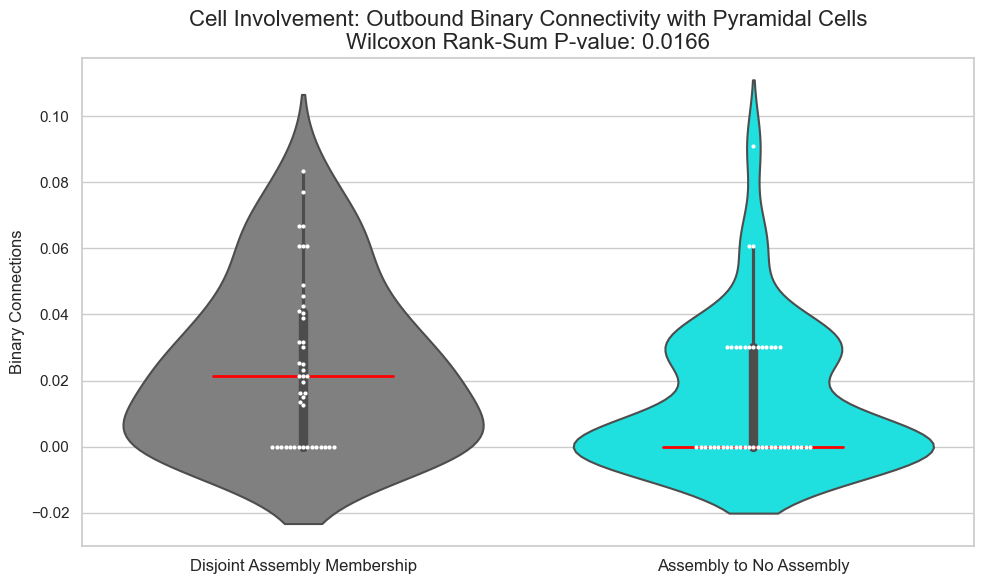


shared_no_a vs shared

shared_no_a vs disjoint

shared_no_a vs no_a_a

shared_no_a vs a_no_a

no_a_a vs shared

no_a_a vs disjoint

no_a_a vs shared_no_a

no_a_a vs a_no_a

a_no_a vs shared

a_no_a vs disjoint

a_no_a vs shared_no_a

a_no_a vs no_a_a


In [9]:
## Outbound Summed Binary
plot_monosynpatic_comparisons(B_out,
                              directionality= "Outbound", 
                              binary_counts = True)


shared vs disjoint

shared vs shared_no_a

shared vs no_a_a

shared vs a_no_a

disjoint vs shared

disjoint vs shared_no_a

disjoint vs no_a_a

disjoint vs a_no_a
Greater:
RanksumsResult(statistic=2.2628920280180274, pvalue=0.011821172974310797)


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_31495/2441621435.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size=12)


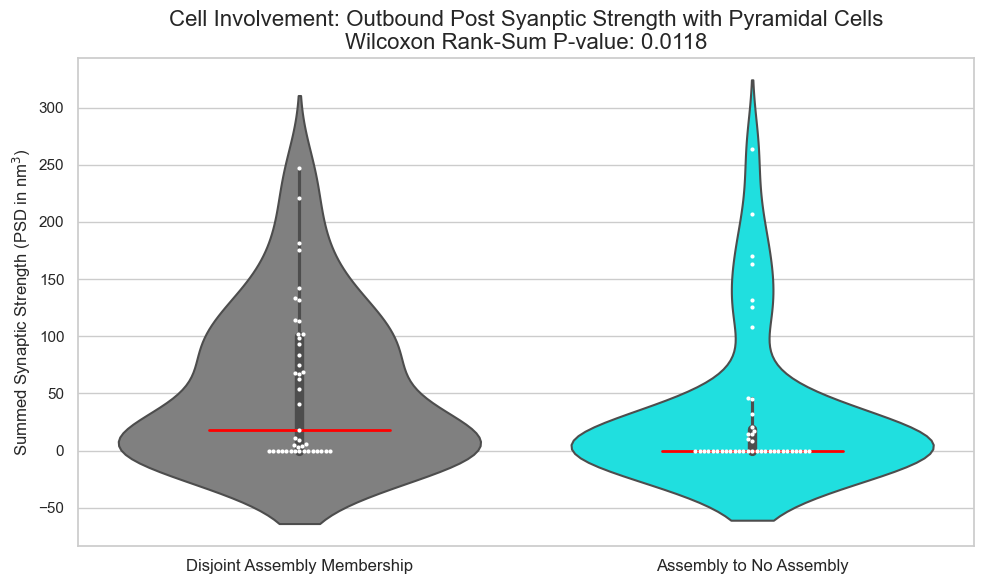


shared_no_a vs shared

shared_no_a vs disjoint

shared_no_a vs no_a_a

shared_no_a vs a_no_a

no_a_a vs shared

no_a_a vs disjoint

no_a_a vs shared_no_a

no_a_a vs a_no_a
Greater:
RanksumsResult(statistic=2.0582263434965364, pvalue=0.019784205462226305)


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_31495/2441621435.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size=12)


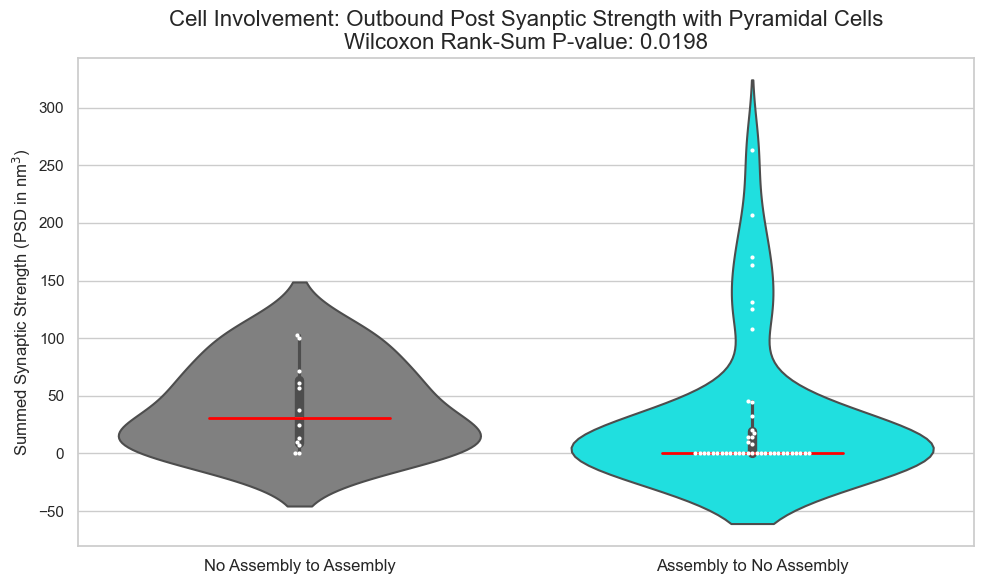


a_no_a vs shared

a_no_a vs disjoint

a_no_a vs shared_no_a

a_no_a vs no_a_a


In [10]:
# Outbound Summed PSDs
plot_monosynpatic_comparisons(W_out,
                              directionality= "Outbound", 
                              summed_psd = True)


shared vs disjoint

shared vs shared_no_a

shared vs no_a_a
Greater:
RanksumsResult(statistic=1.7481986005907446, pvalue=0.04021482192502468)


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_31495/2441621435.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size=12)


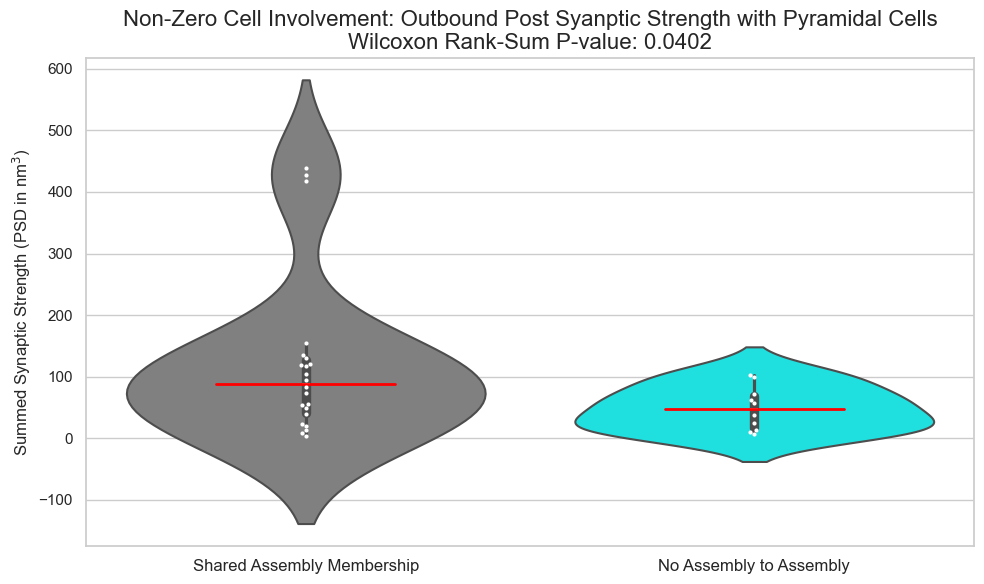


shared vs a_no_a

disjoint vs shared

disjoint vs shared_no_a

disjoint vs no_a_a

disjoint vs a_no_a

shared_no_a vs shared

shared_no_a vs disjoint

shared_no_a vs no_a_a

shared_no_a vs a_no_a

no_a_a vs shared

no_a_a vs disjoint

no_a_a vs shared_no_a

no_a_a vs a_no_a

a_no_a vs shared

a_no_a vs disjoint

a_no_a vs shared_no_a

a_no_a vs no_a_a


In [11]:
# Nonzero Outbound Summed PSDs
plot_monosynpatic_comparisons(W_out,
                              directionality= "Outbound", 
                              summed_psd = True,
                              non_zero = True)


shared vs disjoint

shared vs shared_no_a

shared vs no_a_a

shared vs a_no_a

disjoint vs shared

disjoint vs shared_no_a

disjoint vs no_a_a
Greater:
RanksumsResult(statistic=2.126061116140648, pvalue=0.016749085520890602)


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_31495/2441621435.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size=12)


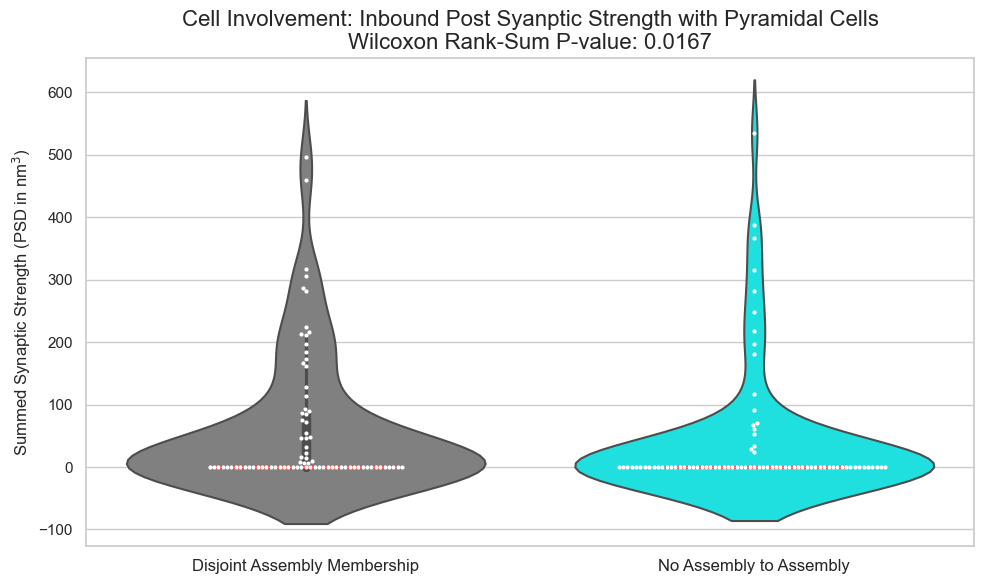


disjoint vs a_no_a

shared_no_a vs shared

shared_no_a vs disjoint

shared_no_a vs no_a_a

shared_no_a vs a_no_a

no_a_a vs shared

no_a_a vs disjoint

no_a_a vs shared_no_a

no_a_a vs a_no_a

a_no_a vs shared

a_no_a vs disjoint

a_no_a vs shared_no_a

a_no_a vs no_a_a


In [12]:
# Inbound Statistical tests: Summed PSD
plot_monosynpatic_comparisons(W_in,
                              directionality= "Inbound", 
                              summed_psd = True)


shared vs disjoint

shared vs shared_no_a

shared vs no_a_a

shared vs a_no_a
Greater:
RanksumsResult(statistic=2.2230945790422183, pvalue=0.013104711559230231)


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_31495/2441621435.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size=12)


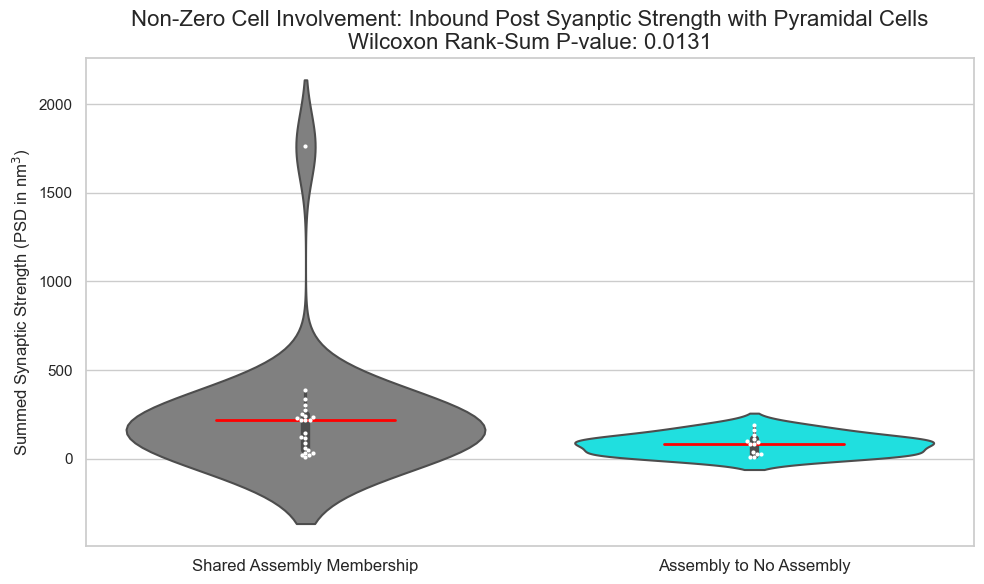


disjoint vs shared

disjoint vs shared_no_a

disjoint vs no_a_a

disjoint vs a_no_a

shared_no_a vs shared

shared_no_a vs disjoint

shared_no_a vs no_a_a

shared_no_a vs a_no_a
Greater:
RanksumsResult(statistic=2.258422227488433, pvalue=0.011959674123974971)


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_31495/2441621435.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size=12)


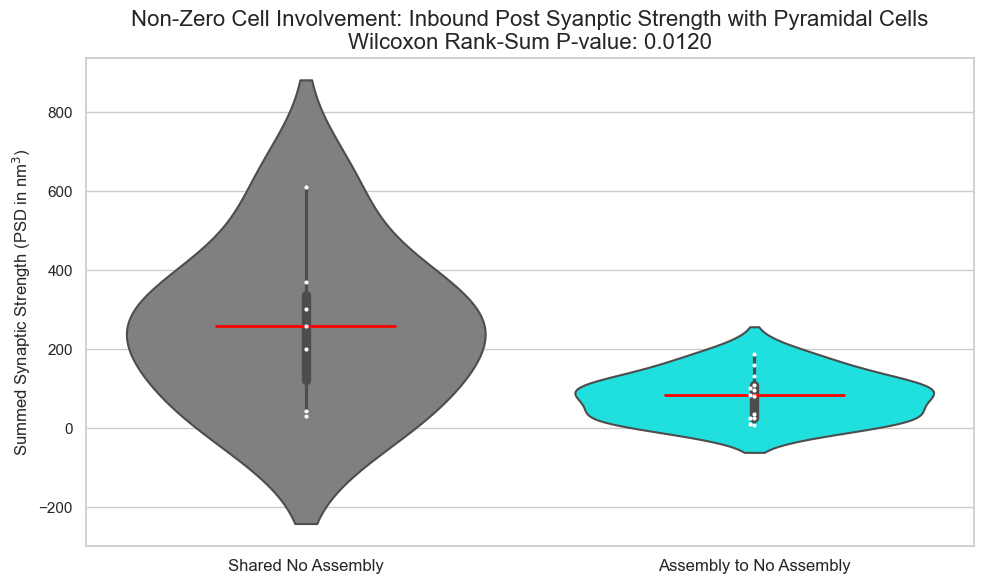


no_a_a vs shared

no_a_a vs disjoint

no_a_a vs shared_no_a

no_a_a vs a_no_a
Greater:
RanksumsResult(statistic=1.841473768758502, pvalue=0.032776080582751284)


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_31495/2441621435.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size=12)


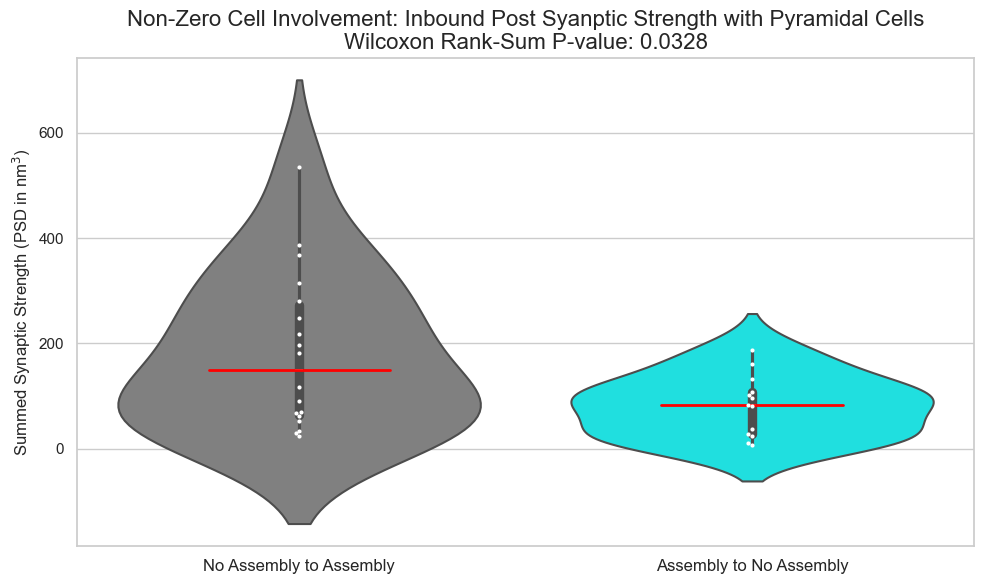


a_no_a vs shared

a_no_a vs disjoint

a_no_a vs shared_no_a

a_no_a vs no_a_a


In [13]:
# Inbound Statistical tests: NONZERO Summed PSD
plot_monosynpatic_comparisons(W_in,
                              directionality= "Inbound", 
                              summed_psd = True,
                              non_zero = True)


shared vs disjoint

shared vs shared_no_a

shared vs no_a_a

shared vs a_no_a

disjoint vs shared

disjoint vs shared_no_a

disjoint vs no_a_a

disjoint vs a_no_a
Greater:
RanksumsResult(statistic=2.1462926296277853, pvalue=0.01592481963059077)


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_31495/2441621435.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size=12)


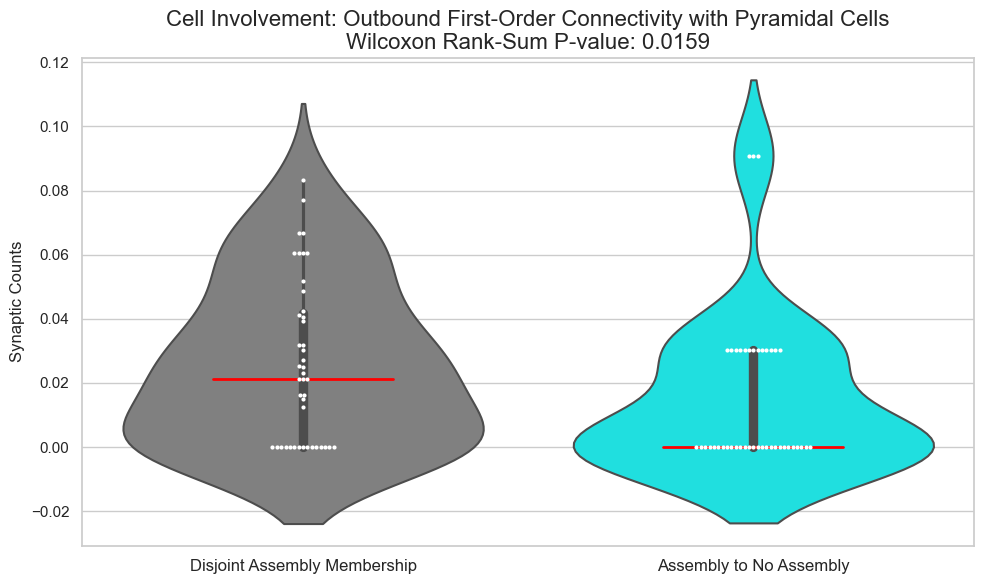


shared_no_a vs shared

shared_no_a vs disjoint

shared_no_a vs no_a_a

shared_no_a vs a_no_a

no_a_a vs shared

no_a_a vs disjoint

no_a_a vs shared_no_a

no_a_a vs a_no_a

a_no_a vs shared

a_no_a vs disjoint

a_no_a vs shared_no_a

a_no_a vs no_a_a


In [14]:
# Outbound Synapse Count Statistical tests
plot_monosynpatic_comparisons(S_out,
                              directionality= "Outbound", 
                              syn_counts = True)


shared vs disjoint

shared vs shared_no_a

shared vs no_a_a

shared vs a_no_a

disjoint vs shared

disjoint vs shared_no_a

disjoint vs no_a_a
Greater:
RanksumsResult(statistic=1.7319037182044603, pvalue=0.041645353314677495)


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_31495/2441621435.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size=12)


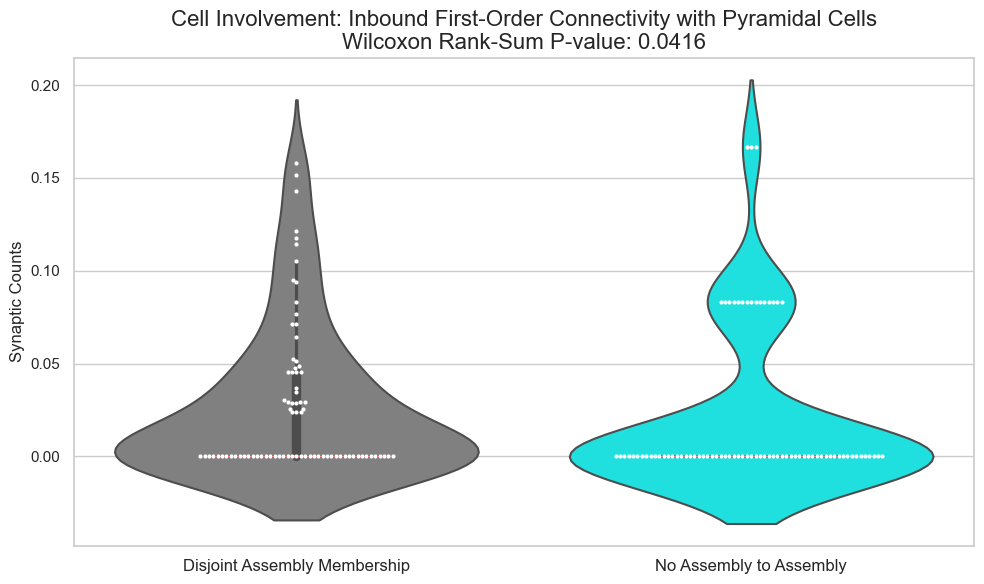


disjoint vs a_no_a

shared_no_a vs shared

shared_no_a vs disjoint

shared_no_a vs no_a_a

shared_no_a vs a_no_a

no_a_a vs shared

no_a_a vs disjoint

no_a_a vs shared_no_a

no_a_a vs a_no_a

a_no_a vs shared

a_no_a vs disjoint

a_no_a vs shared_no_a

a_no_a vs no_a_a


In [15]:
# Inbound Statistical tests: SYNAPSE COUNT
plot_monosynpatic_comparisons(S_in,
                              directionality= "Inbound", 
                              syn_counts = True)



PAIRED SUMMED OUTBOUND BINARY

shared vs disjoint
Greater (shared > disjoint):
WilcoxonResult(statistic=295.0, pvalue=0.5170476729160017)

disjoint vs shared
Greater (disjoint > shared):
WilcoxonResult(statistic=300.0, pvalue=0.4829523270839982)


/Users/jawagnercarena/opt/anaconda3/envs/assembly/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  res = hypotest_fun_out(*samples, **kwds)
/Users/jawagnercarena/opt/anaconda3/envs/assembly/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  res = hypotest_fun_out(*samples, **kwds)


Text(0.5, 1.0, 'PAIRED SUMMED OUTBOUND BINARY: disjoint vs shared')

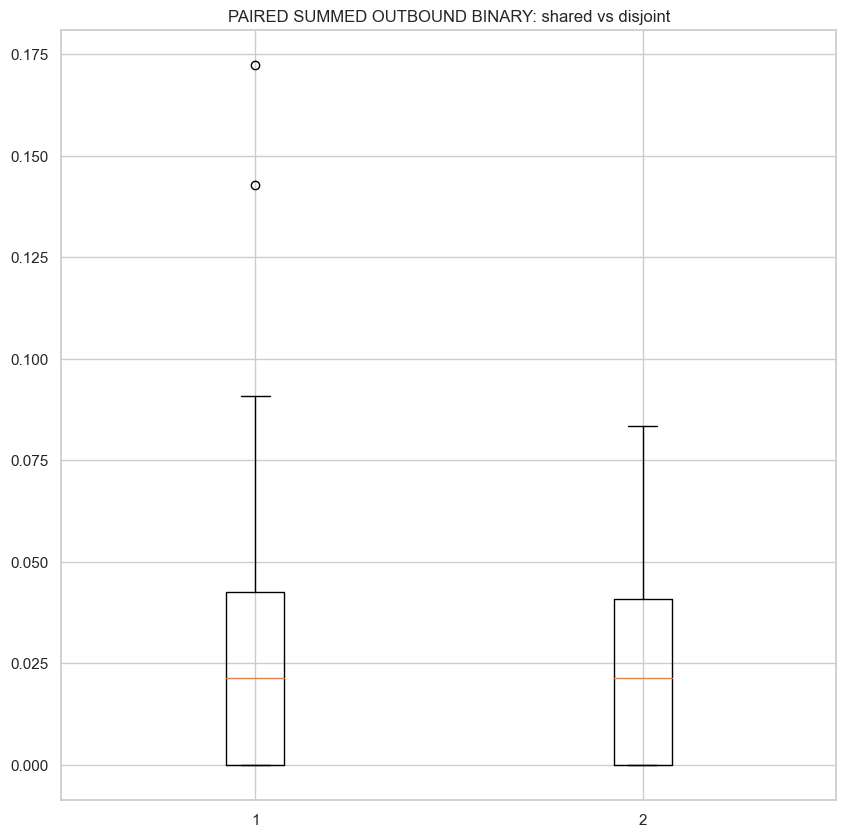

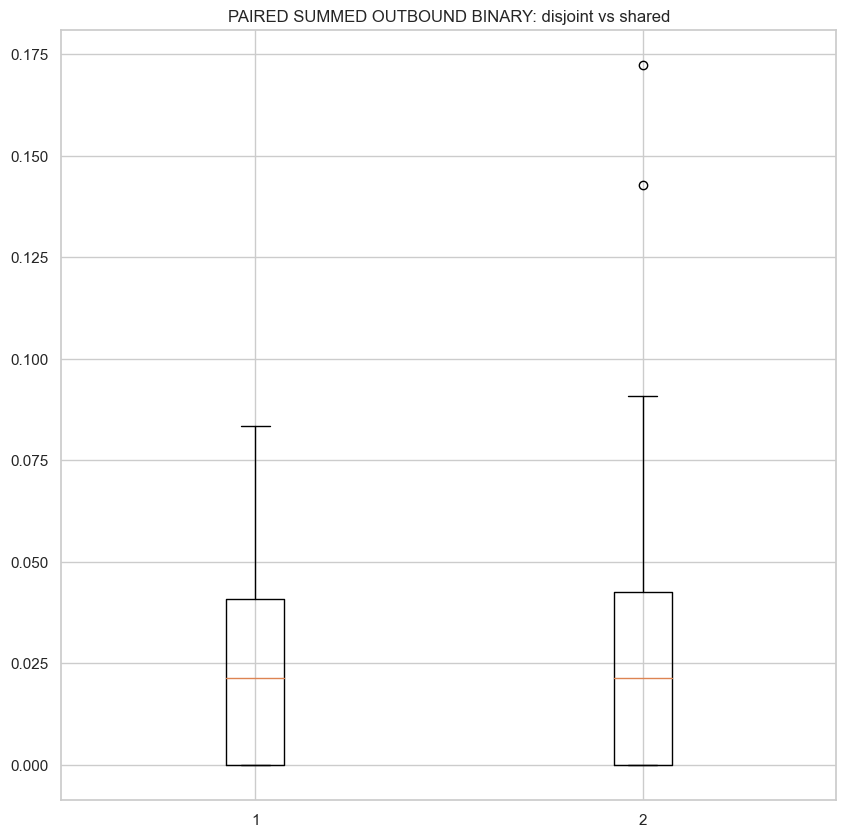

In [16]:
## Paired Outbound Summed Binary

print('\n\nPAIRED SUMMED OUTBOUND BINARY')
c1 = comparison_functions[0]
c2 = comparison_functions[1]
        
print(f'\n{c1.__name__} vs {c2.__name__}')
result = stats.wilcoxon(list(B_out_paired[c1.__name__].values()), list(B_out_paired[c2.__name__].values()), alternative='greater')
# if result.pvalue < 0.05:
print(f'Greater ({c1.__name__} > {c2.__name__}):')
print(result)
plt.figure()
plt.boxplot([list(B_out_paired[c1.__name__].values()), list(B_out_paired[c2.__name__].values())])
plt.title(f'PAIRED SUMMED OUTBOUND BINARY: {c1.__name__} vs {c2.__name__}')

print(f'\n{c2.__name__} vs {c1.__name__}')
result = stats.wilcoxon(list(B_out_paired[c2.__name__].values()), list(B_out_paired[c1.__name__].values()), alternative='greater')
# if result.pvalue < 0.05:
print(f'Greater ({c2.__name__} > {c1.__name__}):')
print(result)
plt.figure()
plt.boxplot([list(B_out_paired[c2.__name__].values()), list(B_out_paired[c1.__name__].values())])
plt.title(f'PAIRED SUMMED OUTBOUND BINARY: {c2.__name__} vs {c1.__name__}')



PAIRED NONZERO SUMMED OUTBOUND SUMMED PSD VOLUME

shared vs disjoint
14 14
Greater (shared > disjoint):
WilcoxonResult(statistic=32.0, pvalue=0.90313720703125)

disjoint vs shared
Greater (disjoint > shared):
WilcoxonResult(statistic=73.0, pvalue=0.1082763671875)


Text(0.5, 1.0, 'PAIRED NONZERO SUMMED OUTBOUND SUMMED PSD VOLUME: disjoint vs shared')

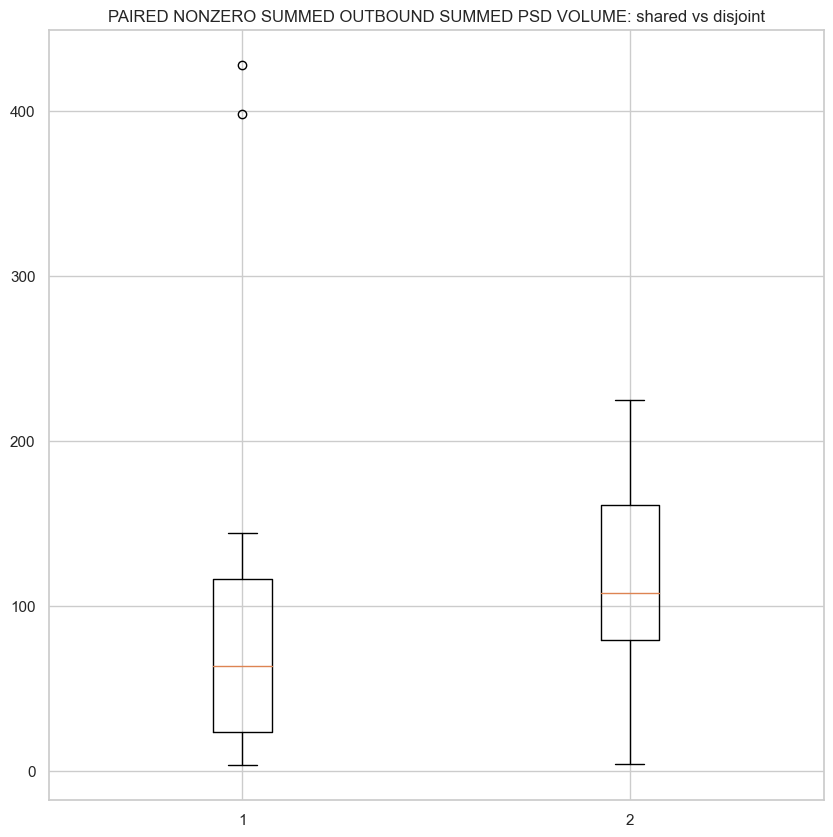

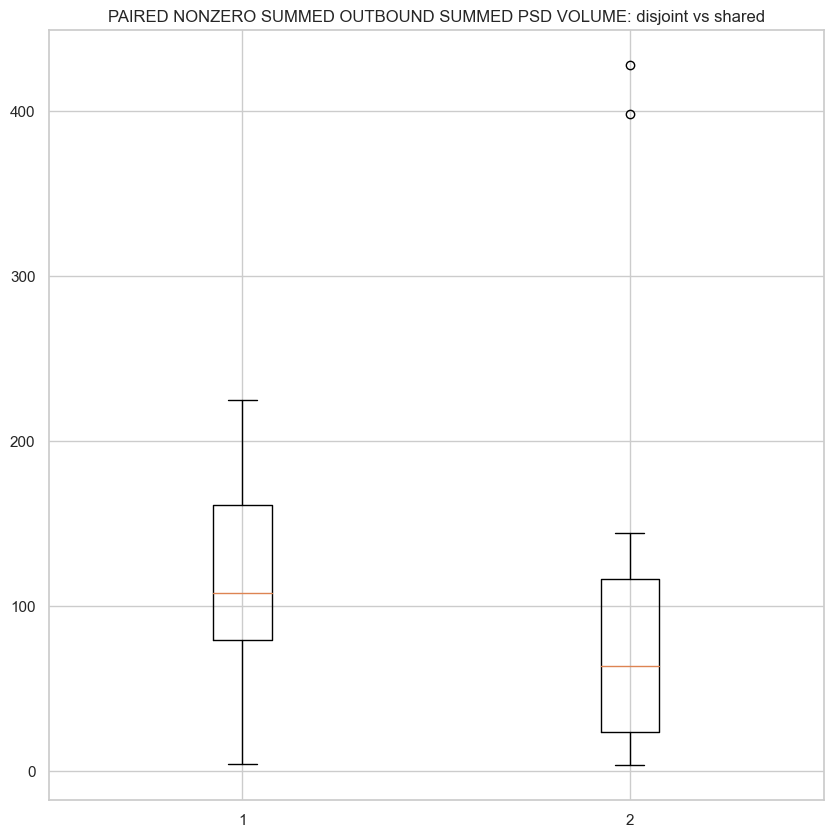

In [17]:
## Paired NONZERO Outbound Summed Binary
print('\n\nPAIRED NONZERO SUMMED OUTBOUND SUMMED PSD VOLUME')
c1 = comparison_functions[0]
c2 = comparison_functions[1]

print(f'\n{c1.__name__} vs {c2.__name__}')
print(len(W_out_paired[c1.__name__].values()), len(W_out_paired[c2.__name__].values()))
result = stats.wilcoxon(list(W_out_paired[c1.__name__].values()), list(W_out_paired[c2.__name__].values()), alternative='greater')
# if result.pvalue < 0.05:
print(f'Greater ({c1.__name__} > {c2.__name__}):')
print(result)
plt.figure()
plt.boxplot([list(W_out_paired[c1.__name__].values()), list(W_out_paired[c2.__name__].values())])
plt.title(f'PAIRED NONZERO SUMMED OUTBOUND SUMMED PSD VOLUME: {c1.__name__} vs {c2.__name__}')

print(f'\n{c2.__name__} vs {c1.__name__}')
result = stats.wilcoxon(list(W_out_paired[c2.__name__].values()), list(W_out_paired[c1.__name__].values()), alternative='greater')
# if result.pvalue < 0.05:
print(f'Greater ({c2.__name__} > {c1.__name__}):')
print(result)
plt.figure()
plt.boxplot([list(W_out_paired[c2.__name__].values()), list(W_out_paired[c1.__name__].values())])
plt.title(f'PAIRED NONZERO SUMMED OUTBOUND SUMMED PSD VOLUME: {c2.__name__} vs {c1.__name__}')

In [18]:
## Chi-Squared test on BINARY CONNECTIVITY
for c1 in comparison_functions:
    for c2 in comparison_functions:
        if c1 != c2:
            print(f'{c1.__name__} vs {c2.__name__} Chi Squared')
            set1 = [v for k, v in b.items() if c1(k[0], k[1], A)]
            set2 = [v for k, v in b.items() if c2(k[0], k[1], A)]

            # Create a contingency table
            contingency_table = np.array([
                [sum(np.array(set1) == 0), sum(np.array(set1) == 1)],
                [sum(np.array(set2) == 0), sum(np.array(set2) == 1)]
            ])

            # Perform the chi-squared test
            chi2_stat, p_val, dof, ex = stats.chi2_contingency(contingency_table)

            print(f"Chi-squared Statistic: {chi2_stat}")
            print(f"P-value: {p_val}")

shared vs disjoint Chi Squared
Chi-squared Statistic: 0.4418834820260927
P-value: 0.5062147769744765
shared vs shared_no_a Chi Squared
Chi-squared Statistic: 0.7092513603796704
P-value: 0.3996924541742918
shared vs no_a_a Chi Squared
Chi-squared Statistic: 1.14079970565214
P-value: 0.28548340910656306
shared vs a_no_a Chi Squared
Chi-squared Statistic: 7.123059964871235
P-value: 0.0076098713524779486
disjoint vs shared Chi Squared
Chi-squared Statistic: 0.4418834820260927
P-value: 0.5062147769744765
disjoint vs shared_no_a Chi Squared
Chi-squared Statistic: 0.18986328953010304
P-value: 0.6630304247984299
disjoint vs no_a_a Chi Squared
Chi-squared Statistic: 0.26176681292738013
P-value: 0.608908920837989
disjoint vs a_no_a Chi Squared
Chi-squared Statistic: 4.819210555059789
P-value: 0.028144232585062278
shared_no_a vs shared Chi Squared
Chi-squared Statistic: 0.7092513603796704
P-value: 0.3996924541742918
shared_no_a vs disjoint Chi Squared
Chi-squared Statistic: 0.18986328953010306
P-

## Higher-Order Connectivity Analysis: Centrality

In [19]:
def produce_centrality_plot(input_centrality_dict: dict,
                            just_pyramidal = False,
                            outdegree = False,
                            indegree = False, 
                            closeness = False, 
                            betweeness = False,
                            save_fig = False):
    
    if outdegree and indegree:
        raise ValueError("Must either be working with outdegree or indegree.")
    if closeness and betweeness:
        raise ValueError("Must either be working with closeness or betweenness.")
    if (outdegree or indegree) and (closeness or betweeness):
        raise ValueError("Must either be working with directionality (indegree/outdegree) or higher-order (betweenness/closeness).")
    
    suffix = "Pyramidal Cells" if just_pyramidal else "All Cells"
    
    # Based on the connectome flags, save it in the right folder, set the correct y_label and plot title
    if outdegree:
        centrality_desc = "Outdegree_Centrality"
        folder = "binary_connectome"
        suffix = "Outdegree Centrality with " + suffix
        y_lab = "Outdegree Centrality"
    elif indegree:
        centrality_desc = "Indegree_Centrality"
        folder = "binary_connectome"
        suffix = "Indegree Centrality with " + suffix
        y_lab = "Indegree Centrality"
    elif closeness: 
        centrality_desc = "Closeness_Centrality"
        folder = "binary_connectome"
        suffix = "Closeness Centrality with " + suffix
        y_lab = "Closeness Centrality"
    elif betweeness:
        centrality_desc = "Betweeness_Centrality"
        folder = "binary_connectome"
        suffix = "Betweeness Centrality with " + suffix
        y_lab = "Betweeness Centrality"
    else:
        raise ValueError("Must Specify Degree")

    centrality_dict = {}
    for key in input_centrality_dict.keys():
        centrality_dict[key] = np.array(input_centrality_dict[key])

    all_arr = [centrality_dict['No A'], centrality_dict['All A']]
    result = stats.ranksums(centrality_dict['All A'], centrality_dict['No A'], 'greater')

    # Create a figure with specific size
    _, ax = plt.subplots(figsize=(10, 6))  # Width = 12 inches, Height = 6 inches
    sns.set_theme(style="whitegrid")

    # Create the violin plot
    sns.violinplot(data= all_arr,
                inner='box',  # Show quartiles and median (similar to boxplot)
                linewidth=1.5,
                split=False,  # Not splitting, as we're comparing two distributions
                palette=["grey", "cyan"],  # Use the same palette as before
                ax=ax
                )
    
    # Overlay a stripplot to show individual points, including outliers
    sns.swarmplot(data= all_arr,
                color='white',  # Use black color to differentiate points
                edgecolor= 'grey',
                size = 3,
                ax=ax
                )
    
    # Calculate and add the median line
    medians = [np.median(np.array(centrality_dict['No A'])), np.median(np.array(centrality_dict['All A']))]
    for i, median in enumerate(medians):
        ax.plot([i - 0.2, i + 0.2], [median, median], color='red', linestyle='-', linewidth=2, label="Median" if i == 0 else "")

    # Set the x-axis labels
    x_ticks = ["No Assembly Membership", 'Assigned Assembly Membership']
    ax.set_xticklabels(x_ticks, size=12)

    # Set a multiline title to include the p-value, add y_label
    ax.set_title(f'Cell Involvement: {suffix}\nWilcoxon Rank-Sum P-value: {result.pvalue:.4f}', size=16)
    ax.set_ylabel(y_lab, size=12)

    # # Create a figure with specific size
    # _, ax = plt.subplots(figsize=(12, 8))  # Width = 12 inches, Height = 6 inches

    # sns.set_theme(style="whitegrid")
    # sns.boxplot(data=all_arr,
    #                 notch= False, showcaps=True,
    #                 flierprops={"marker": "x"},
    #                 medianprops={"color": "coral"},
    #                 palette= colors,
    #                 ax = ax
    #             )
    # ax.set_xticklabels(x_ticks, size = 14)
    # ax.set_title(f'{prefix}Assembly Cell Involvement: {suffix}', size = 16)
    # ax.set_ylabel(y_lab, size = 14)
    # plt.xticks(rotation=45)

    # # If you want to print P-Values, place them on the plot above the median

    # if show_p_vals:
    #     medians = np.array(arr_medians)
    #     vertical_offset = medians * 0.005 # offset from median for display
            
    #     for xtick in ax.get_xticks():
    #         if xtick != 0:
    #             ax.text(xtick, medians[xtick] + vertical_offset[xtick], p_values[xtick],  # type: ignore
    #                     horizontalalignment='center', fontsize=10, color='black', weight='semibold')

    fig_title = f"{centrality_desc}_Grouped_Assemblies_Boxplot.png"
    
    if save_fig:
        plt.savefig(f'{results_folder}/{folder}/{fig_title}', dpi = 1200)
        print("Saved!")
    plt.tight_layout()
    plt.show()

### All Cells Proofread Connectome

In [20]:
results_folder = "all_cells_results"

In [21]:
# Pull Data from LSMM Data
with open('all_cells_proofread_connectome.json') as f:
    lsmm_json_input = json.load(f)
v1dd_data = LSMMData.LSMMData(lsmm_json_input)

data_a = v1dd_data.data
params_a = v1dd_data.params
dirs_a = v1dd_data.dirs
mappings_a = v1dd_data.mappings

Generating Connectome...


100%|██████████| 137706/137706 [00:15<00:00, 8966.12it/s]


Generating Connectome...


100%|██████████| 137706/137706 [00:20<00:00, 6774.45it/s]


In [22]:
# Calculate Centrality Measurements
binary_connectome = data_a['structural']['binary_connectome']
all_to_all_graph = nx.from_numpy_array(binary_connectome, create_using=nx.DiGraph)

indegree_centrality = nx.in_degree_centrality(all_to_all_graph)
outdegree_centrality = nx.out_degree_centrality(all_to_all_graph)
closeness_centrality = nx.closeness_centrality(all_to_all_graph, wf_improved = True)
betweeness_centrality = nx.betweenness_centrality(all_to_all_graph, normalized= True)

In [23]:
connectome_index_by_assemblies = mappings_a['connectome_indexes_by_assembly']
assembly_connectome_indexes = np.unique(np.concatenate([val for key, val in connectome_index_by_assemblies.items() if key != 'No A']))
no_assembly_connectome_indexes = np.array(list(connectome_index_by_assemblies['No A']))

# Produce Grouped Counts for Inbound and Outbound Connections
indegree_centrality_by_grouped_membership = {'No A': [], 'All A': []}
outdegree_centrality_by_grouped_membership = {'No A': [], 'All A': []}
closeness_centrality_by_grouped_membership = {'No A': [], 'All A': []}
betweeness_centrality_by_grouped_membership = {'No A': [], 'All A': []}

# Add to dictionaries to plot
for assembly_cell_idx in assembly_connectome_indexes:
    indegree_centrality_by_grouped_membership['All A'].append(indegree_centrality[assembly_cell_idx])
    outdegree_centrality_by_grouped_membership['All A'].append(outdegree_centrality[assembly_cell_idx])
    closeness_centrality_by_grouped_membership['All A'].append(closeness_centrality[assembly_cell_idx])
    betweeness_centrality_by_grouped_membership['All A'].append(betweeness_centrality[assembly_cell_idx])
for no_assembly_cell_idx in no_assembly_connectome_indexes:
    indegree_centrality_by_grouped_membership['No A'].append(indegree_centrality[no_assembly_cell_idx])
    outdegree_centrality_by_grouped_membership['No A'].append(outdegree_centrality[no_assembly_cell_idx])
    closeness_centrality_by_grouped_membership['No A'].append(closeness_centrality[no_assembly_cell_idx])
    betweeness_centrality_by_grouped_membership['No A'].append(betweeness_centrality[no_assembly_cell_idx])

In [24]:
len(assembly_connectome_indexes)

43

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_31495/2819139384.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size=12)


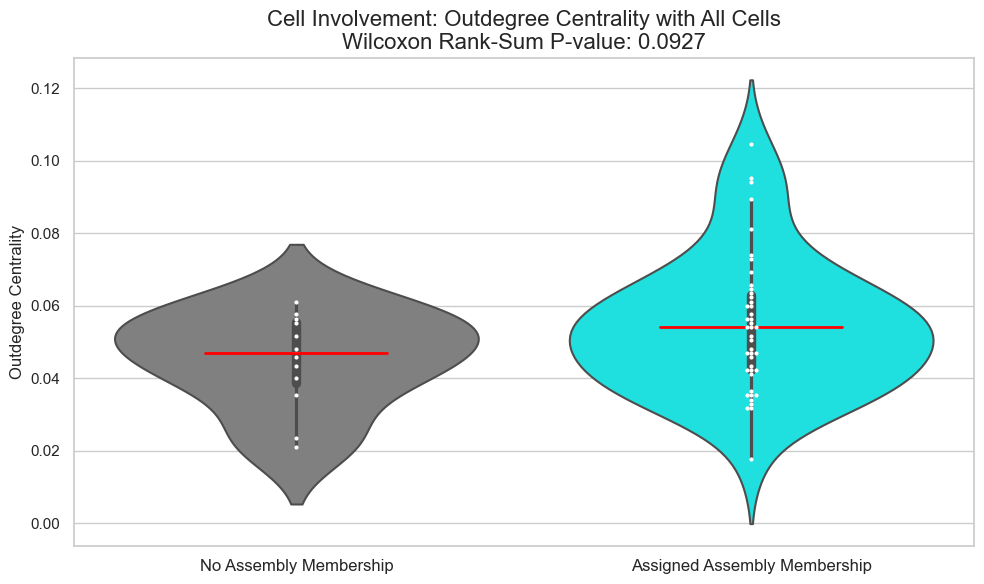

In [25]:
produce_centrality_plot(outdegree_centrality_by_grouped_membership,
                        outdegree = True)

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_31495/2819139384.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size=12)


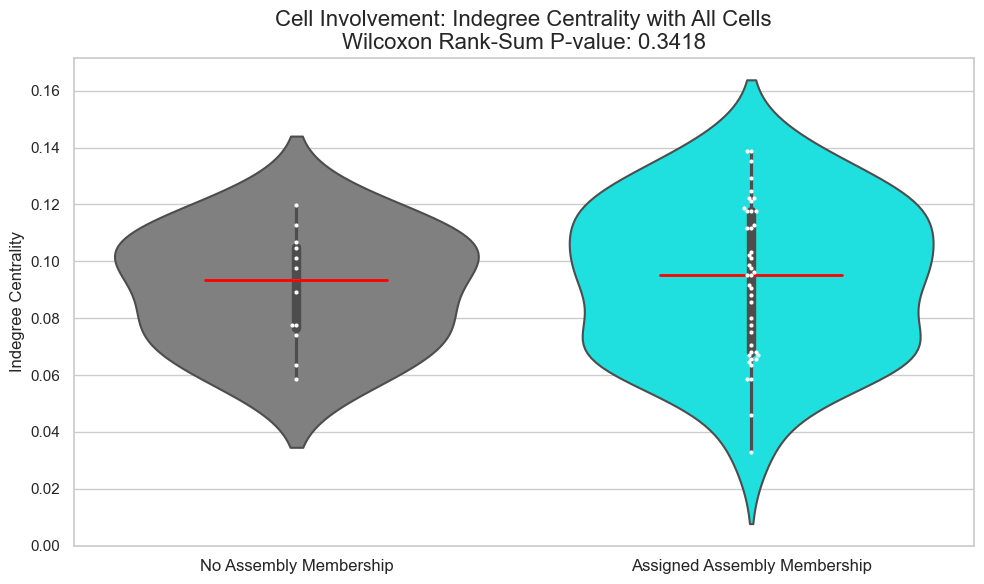

In [26]:
produce_centrality_plot(indegree_centrality_by_grouped_membership,
                        indegree = True)

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_31495/2819139384.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size=12)


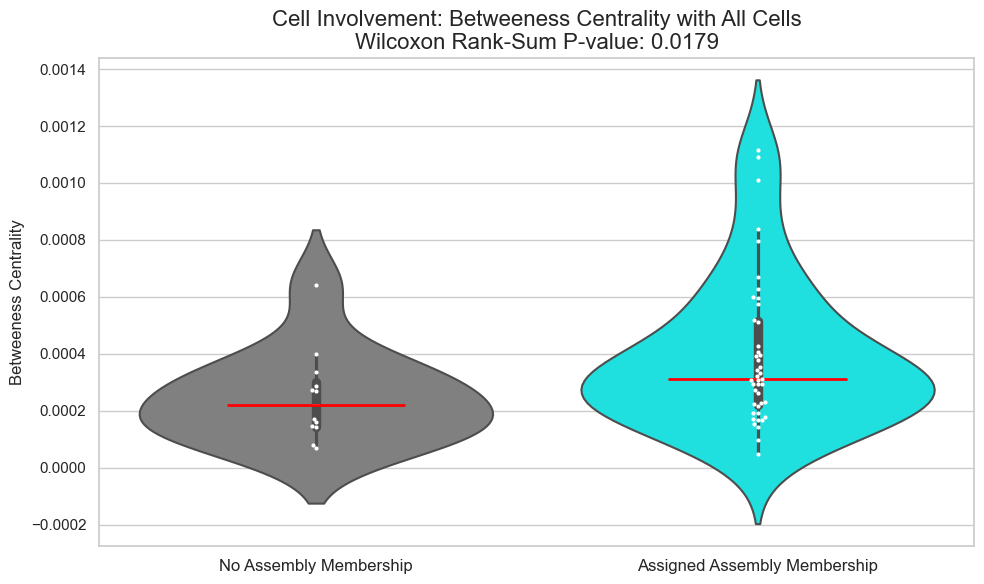

In [27]:
produce_centrality_plot(betweeness_centrality_by_grouped_membership,
                        betweeness = True)

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_31495/2819139384.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size=12)


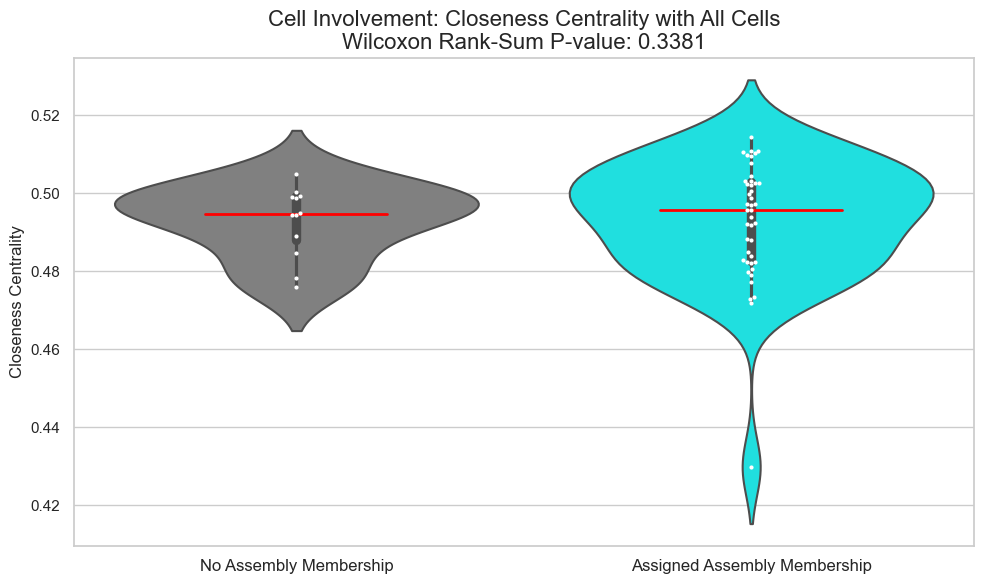

In [28]:
produce_centrality_plot(closeness_centrality_by_grouped_membership,
                        closeness = True)

### Pyramidal Cells Proofread Connectome

In [29]:
results_folder = "pyr_only_results"

In [30]:
# Pull Data from LSMM Data
with open('pyr_cells_proofread_connectome.json') as f:
    lsmm_json_input = json.load(f)
v1dd_data = LSMMData.LSMMData(lsmm_json_input)

data_a = v1dd_data.data
params_a = v1dd_data.params
dirs_a = v1dd_data.dirs
mappings_a = v1dd_data.mappings

Filtering to pyramidal cells only
459
Generating Connectome...


100%|██████████| 4565/4565 [00:00<00:00, 11292.75it/s]


Generating Connectome...


100%|██████████| 4565/4565 [00:00<00:00, 8016.21it/s]


In [31]:
# Calculate Centrality Measurements
binary_connectome = data_a['structural']['binary_connectome']
all_to_all_graph = nx.from_numpy_array(binary_connectome, create_using=nx.DiGraph)

indegree_centrality = nx.in_degree_centrality(all_to_all_graph)
outdegree_centrality = nx.out_degree_centrality(all_to_all_graph)
closeness_centrality = nx.closeness_centrality(all_to_all_graph, wf_improved = True)
betweeness_centrality = nx.betweenness_centrality(all_to_all_graph, normalized= True)

In [32]:
connectome_index_by_assemblies = mappings_a['connectome_indexes_by_assembly']
assembly_connectome_indexes = np.unique(np.concatenate([val for key, val in connectome_index_by_assemblies.items() if key != 'No A']))
no_assembly_connectome_indexes = np.array(list(connectome_index_by_assemblies['No A']))

# Produce Grouped Counts for Inbound and Outbound Connections
indegree_centrality_by_grouped_membership = {'No A': [], 'All A': []}
outdegree_centrality_by_grouped_membership = {'No A': [], 'All A': []}
closeness_centrality_by_grouped_membership = {'No A': [], 'All A': []}
betweeness_centrality_by_grouped_membership = {'No A': [], 'All A': []}

# Add to dictionaries to plot
for assembly_cell_idx in assembly_connectome_indexes:
    indegree_centrality_by_grouped_membership['All A'].append(indegree_centrality[assembly_cell_idx])
    outdegree_centrality_by_grouped_membership['All A'].append(outdegree_centrality[assembly_cell_idx])
    closeness_centrality_by_grouped_membership['All A'].append(closeness_centrality[assembly_cell_idx])
    betweeness_centrality_by_grouped_membership['All A'].append(betweeness_centrality[assembly_cell_idx])
for no_assembly_cell_idx in no_assembly_connectome_indexes:
    indegree_centrality_by_grouped_membership['No A'].append(indegree_centrality[no_assembly_cell_idx])
    outdegree_centrality_by_grouped_membership['No A'].append(outdegree_centrality[no_assembly_cell_idx])
    closeness_centrality_by_grouped_membership['No A'].append(closeness_centrality[no_assembly_cell_idx])
    betweeness_centrality_by_grouped_membership['No A'].append(betweeness_centrality[no_assembly_cell_idx])

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_31495/2819139384.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size=12)


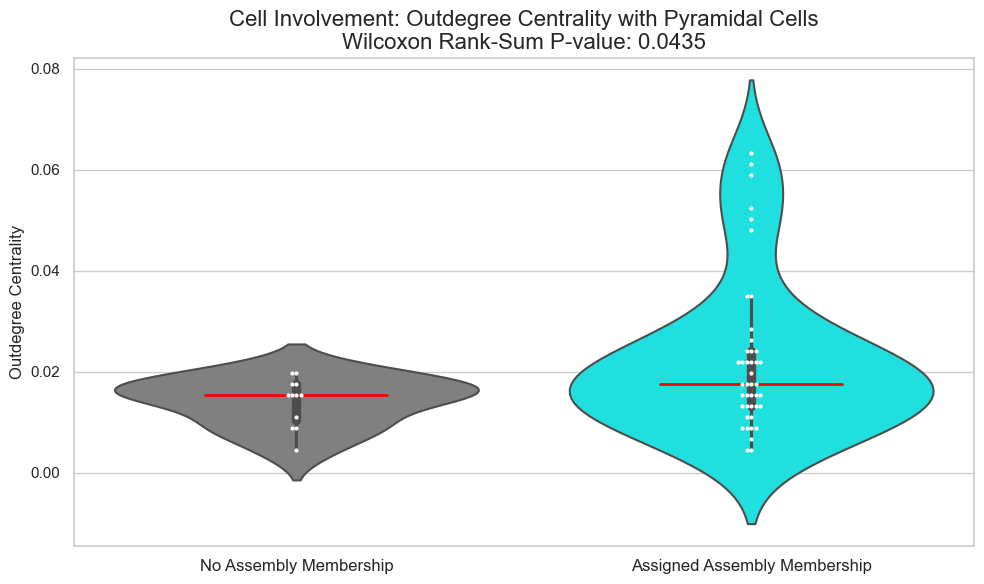

In [33]:
produce_centrality_plot(outdegree_centrality_by_grouped_membership,
                        outdegree = True,
                        just_pyramidal = True)

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_31495/2819139384.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size=12)


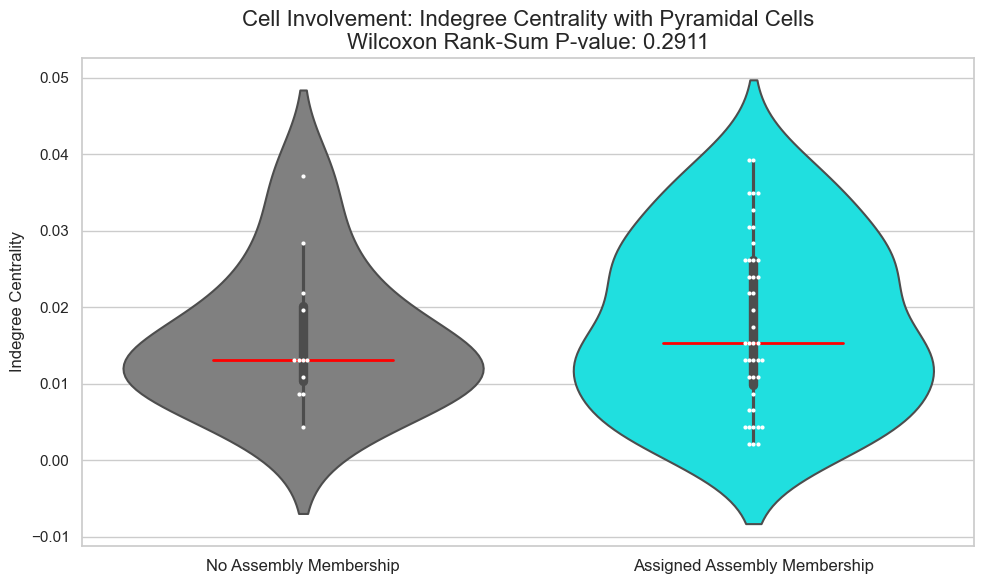

In [34]:
produce_centrality_plot(indegree_centrality_by_grouped_membership,
                        indegree = True,
                        just_pyramidal = True)

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_31495/2819139384.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size=12)


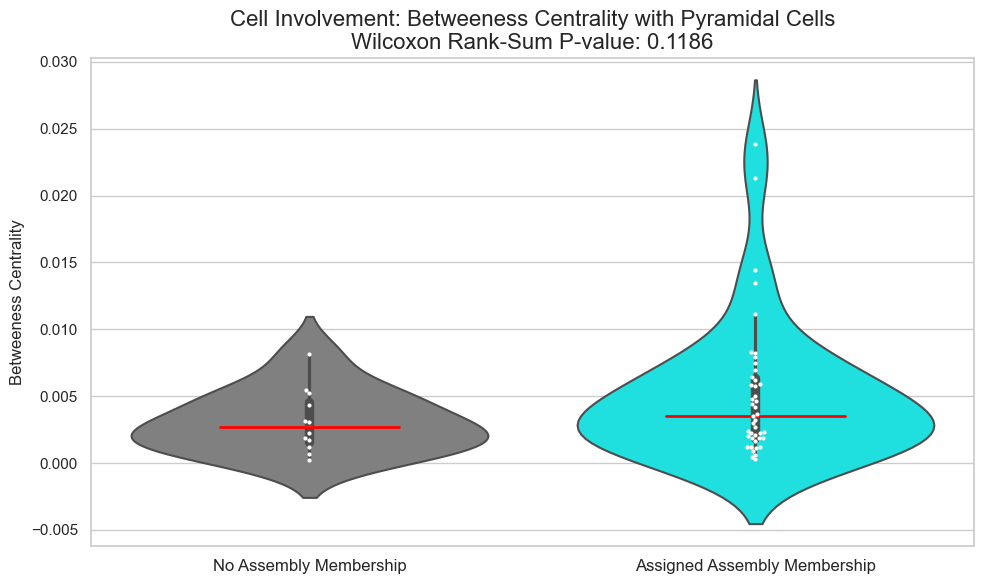

In [35]:
produce_centrality_plot(betweeness_centrality_by_grouped_membership,
                        betweeness = True,
                        just_pyramidal = True)

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_31495/2819139384.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size=12)


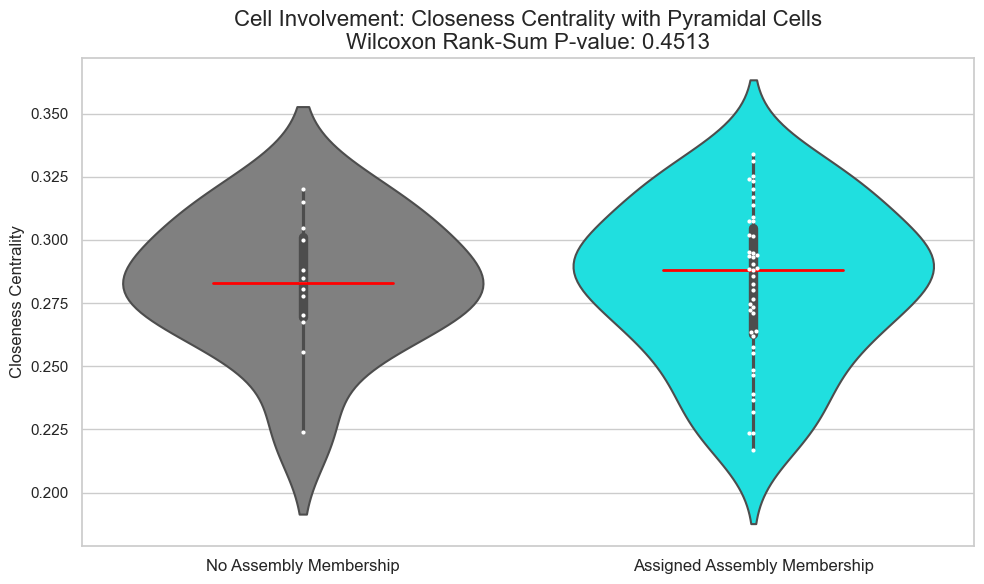

In [36]:
produce_centrality_plot(closeness_centrality_by_grouped_membership,
                        closeness = True,
                        just_pyramidal = True)

## Higher-Order Conectivity Analysis: Chain Motifs

In [37]:
def plot_diasynaptic_comparisons(comparison_dict: dict,
                                    directionality: str,
                                    feed_forward_inh = False,
                                    binary_counts = False,
                                    syn_counts = False, 
                                    summed_psd = False,
                                    non_zero = False,
                                    save_fig = False):
    
    x_labels_by_func = {"shared": "Shared Assembly Membership", 
                        "disjoint": "Disjoint Assembly Membership", 
                        "shared_no_a": "Shared No Assembly", 
                        "no_a_a": "No Assembly to Assembly", 
                        "a_no_a": "Assembly to No Assembly"}

    if binary_counts and syn_counts:
        raise ValueError("Must either be working with binary or synaptic count connectome.")
    if (binary_counts or syn_counts) and summed_psd:
        raise ValueError("Must either be working with PSD or connectivity.")
    
    chain_desc = "Feed Forward Inhibitory Chains" if feed_forward_inh else "Excitatory Pyramidal Chains"

    # Based on the connectome flags, save it in the right folder, set the correct y_label and plot title
    if binary_counts:
        connectome_desc = "Binary"
        folder = "binary_connectome"
        suffix = f"{directionality} Binary Connectivity in {chain_desc}"
        y_lab = "Binary Connections"
    elif summed_psd:
        connectome_desc = "Summed_PSD"
        folder = "summed_size_connectome"
        suffix = f"{directionality} Post Syanptic Strength in {chain_desc}"
        y_lab = "Summed Synaptic Strength (PSD in nm$^3$)"
    elif syn_counts:
        connectome_desc = "Syn_Counts"
        folder = "synapse_count_connectome"
        suffix = f"{directionality} First-Order Connectivity in {chain_desc}"
        y_lab = "Synaptic Counts"
    else:
        raise ValueError("Must specify which connectome is being used.")
    

    prefix = "Cell Involvement"
    prefix = "Non-Zero " + prefix if non_zero else prefix

    for c1 in comparison_functions:
        for c2 in comparison_functions:
            if c1.__name__ != c2.__name__:
                print(f'\n{c1.__name__} vs {c2.__name__}')
                if non_zero:
                    c1_set = np.array(list(comparison_dict[c1.__name__].values()))[np.array(list(comparison_dict[c1.__name__].values())).nonzero()[0]]
                    c2_set = np.array(list(comparison_dict[c2.__name__].values()))[np.array(list(comparison_dict[c2.__name__].values())).nonzero()[0]]
                else:
                    c1_set = np.array(list(comparison_dict[c1.__name__].values()))
                    c2_set = np.array(list(comparison_dict[c2.__name__].values()))
                result = stats.ranksums(c1_set, c2_set, alternative='greater')
                if result.pvalue < 0.05:
                    print('Greater:')
                    print(result)
                    
                    # Create a figure with specific size
                    _, ax = plt.subplots(figsize=(10, 6))  # Width = 12 inches, Height = 6 inches
                    sns.set_theme(style="whitegrid")

                    # Create the violin plot
                    sns.violinplot(data=[c1_set, c2_set],
                                inner='box',  # Show quartiles and median (similar to boxplot)
                                linewidth=1.5,
                                split=False,  # Not splitting, as we're comparing two distributions
                                palette=["grey", "cyan"],  # Use the same palette as before
                                ax=ax
                                )
                    
                    # Overlay a stripplot to show individual points, including outliers
                    sns.swarmplot(data=[c1_set, c2_set],
                                color='white',  # Use black color to differentiate points
                                edgecolor= 'grey',
                                size = 3,
                                ax=ax
                                )
                    
                    # Calculate and add the median line
                    medians = [np.median(c1_set), np.median(c2_set)]
                    for i, median in enumerate(medians):
                        ax.plot([i - 0.2, i + 0.2], [median, median], color='red', linestyle='-', linewidth=2, label="Median" if i == 0 else "")

                    # Set the x-axis labels
                    x_ticks = [x_labels_by_func[c1.__name__], x_labels_by_func[c2.__name__]]
                    ax.set_xticklabels(x_ticks, size=12)

                    # Set a multiline title to include the p-value, add y_label
                    ax.set_title(f'{prefix}: {suffix}\nWilcoxon Rank-Sum P-value: {result.pvalue:.4f}', size=16)
                    ax.set_ylabel(y_lab, size=12)

                    # sns.set_theme(style="whitegrid")
                    # sns.boxplot(data=[c1_set, c2_set],
                    #                 notch= False, showcaps=True,
                    #                 flierprops={"marker": "x"},
                    #                 medianprops={"color": "red"}, #coral
                    #                 palette= ["grey", "cyan"],
                    #                 ax = ax
                    #             )
                    # x_ticks = [c1.__name__, c2.__name__]
                    # ax.set_xticklabels(x_ticks, size = 12)
                    # ax.set_title(f'{prefix}: {suffix}', size = 16)
                    # ax.set_ylabel(y_lab, size = 12)
                    # plt.xticks(rotation=45)
                    # plt.figure()
                    # # plt.boxplot([list(comparison_dict[c1.__name__].values()), list(comparison_dict[c2.__name__].values())])
                    # # plt.title(f'SUMMED OUTBOUND BINARY: {c1.__name__} vs {c2.__name__}')
                    
                    fig_title = f"{connectome_desc}_Grouped_Assemblies_Boxplot.png"
    
                    if save_fig:
                        plt.savefig(f'{results_folder}/{folder}/{fig_title}', dpi = 1200)
                    plt.tight_layout()
                    plt.show()


### Prep Data

In [38]:
with open('all_cells_proofread_connectome.json') as f:
    loaded_json = json.load(f)
my_data = LSMMData.LSMMData(loaded_json)
# with open('pyr_rect.data', 'wb') as f:
#     pickle.dump(my_data, f)

data_a = my_data.data
params_a = my_data.params
dirs_a = my_data.dirs
mappings_a = my_data.mappings

Generating Connectome...


100%|██████████| 137706/137706 [00:14<00:00, 9646.28it/s]


Generating Connectome...


100%|██████████| 137706/137706 [00:19<00:00, 7037.05it/s]


In [39]:
# Make a graph
cell_table = data_a['structural']['pre_cell'].copy()
cell_table['connectome_index'] = cell_table.index
post_cell_table = data_a['structural']['post_cell'].copy()
post_cell_table['connectome_index'] = post_cell_table.index

synapse_table = data_a['structural']['synapse']
# adjacency_matrix = data_a['structural']['binary_connectome']
binary_connectome = data_a['structural']['binary_connectome']
summed_size_connectome = data_a['structural']['summed_size_connectome']
pyr_graph = nx.from_numpy_array(binary_connectome, create_using=nx.DiGraph)

# Or uncomment below to generate new motif analysis results (Can take quite a while on larger graphs)
# Motif Analysis with DotMotif: 2 Chain, All Pyr
executor = GrandIsoExecutor(graph= pyr_graph)
chain_defs = Motif("""
                A -> B
                B -> C
              """)

chain_results = executor.find(chain_defs)

two_chain_results_array = np.array([list(c.values()) for c in tqdm(chain_results)])

### Pool necessary Data
chain_count_string_array = ['pyr_cell_2chain']
individual_assembly_indexes = [mappings_a['connectome_indexes_by_assembly'][f'A {i}'] for i in range(1,16)]
individual_post_assembly_indexes = [mappings_a['post_connectome_indexes_by_assembly'][f'A {i}'] for i in range(1,16)]

coregistered_post_cell_indexes = mappings_a['assemblies_by_post_connectome_index'].keys()
coregistered_cell_indexes = mappings_a['assemblies_by_connectome_index'].keys()
no_a_cell_indexes = mappings_a['connectome_indexes_by_assembly']['No A']
no_a_post_cell_indexes = mappings_a['post_connectome_indexes_by_assembly']['No A']
pooled_assembly_indexes = list(set(coregistered_cell_indexes) - set(no_a_cell_indexes))
pooled_assembly_post_indexes = list(set(coregistered_post_cell_indexes) - set(no_a_post_cell_indexes))

assembly_to_root_ids = mappings_a['pt_root_ids_by_assembly']
assembly_root_ids_set = set(mappings_a['assemblies_by_pt_root_id'].keys())

# Filter synapses_table to only synapses between two assembly cells (including No A)
synapses_df = synapse_table[synapse_table['pre_pt_root_id'].isin(assembly_root_ids_set)]
synapses_df = synapses_df[synapses_df['post_pt_root_id'].isin(assembly_root_ids_set)]

# Filter cell tables to only assembly cells (including 'No A')
assembly_cell_table = cell_table[cell_table['pt_root_id'].isin(assembly_root_ids_set)]
assembly_post_cell_table = post_cell_table[post_cell_table['pt_root_id'].isin(assembly_root_ids_set)]

assembly_pre_root_ids = set(assembly_cell_table['pt_root_id'].values)
assembly_post_root_ids = set(assembly_post_cell_table['pt_root_id'].values)
all_root_ids = assembly_pre_root_ids | assembly_post_root_ids

100%|██████████| 6052393/6052393 [00:04<00:00, 1279015.70it/s]


In [42]:
classification_map = cell_table.set_index('connectome_index')['classification_system'].to_dict() # Map to tell us if its Excitatory or Inhibitory 
backup_assembly_pre_root_ids = assembly_pre_root_ids
backup_assembly_post_root_ids = assembly_post_root_ids

# Initialize dictionaries for outbound weights
W_out_feed_forward_inhibition_chains = {c.__name__: {} for c in comparison_functions}
W_out_excitatory_chains = {c.__name__: {} for c in comparison_functions}

for cond_function in comparison_functions:
    for j in assembly_pre_root_ids:
        # Exclude the current pre-synaptic cell from the post-synaptic candidate set
        assembly_post_root_ids = backup_assembly_post_root_ids - set([j])

        normalizing_factor = 0
        for i in assembly_post_root_ids:
            # Check if pre-synaptic cell 'j' satisfies the condition with post-synaptic cell 'i'
            if cond_function(j, i, A) and j != i:
                pre_idx = mappings_a['pt_root_id_to_connectome_index'][j]
                post_idx = mappings_a['pt_root_id_to_connectome_index'][i]

                # Filter chains where cell A in chain matches pre_idx and cell C matches post_idx
                temporary_chain_results = two_chain_results_array[(two_chain_results_array[:, 0] == pre_idx) & (two_chain_results_array[:, 2] == post_idx)]

                # Add to the normalizing factor the number of realized chains between pre_cell (position A in chain) and post cell (position C in chain)
                normalizing_factor += len(temporary_chain_results)

                # Continue if no matches are found
                if len(temporary_chain_results) == 0:
                    continue

                for chain in temporary_chain_results:  # Summing over possible intermediate nodes (k's)
                    cell_a, cell_b, cell_c = chain

                    # Classification of the intermediate node (cell B)
                    if classification_map[cell_b] == 'inhibitory':
                        W_out_feed_forward_inhibition_chains[cond_function.__name__][j] = (
                            W_out_feed_forward_inhibition_chains[cond_function.__name__].get(j, 0) +
                            summed_size_connectome[cell_a, cell_b] * summed_size_connectome[cell_b, cell_c]
                        )
                    elif classification_map[cell_b] == 'excitatory':
                        W_out_excitatory_chains[cond_function.__name__][j] = (
                            W_out_excitatory_chains[cond_function.__name__].get(j, 0) +
                            summed_size_connectome[cell_a, cell_b] * summed_size_connectome[cell_b, cell_c]
                        )

        # After accumulating the weights for all 'i' for this specific 'j', normalize them by the total number of realized connections
        if j in W_out_feed_forward_inhibition_chains[cond_function.__name__]:
            W_out_feed_forward_inhibition_chains[cond_function.__name__][j] /= normalizing_factor

        if j in W_out_excitatory_chains[cond_function.__name__]:
            W_out_excitatory_chains[cond_function.__name__][j] /= normalizing_factor

# Initialize dictionaries for inbound weights
W_in_feed_forward_inhibition_chains = {c.__name__: {} for c in comparison_functions}
W_in_excitatory_chains = {c.__name__: {} for c in comparison_functions}

for cond_function in comparison_functions:
    for i in assembly_post_root_ids:
        # Exclude the current post-synaptic cell from the pre-synaptic candidate set
        assembly_pre_root_ids = backup_assembly_pre_root_ids - set([i])

        normalizing_factor = 0
        for j in assembly_pre_root_ids:
            # Check if pre-synaptic cell 'j' satisfies the condition with post-synaptic cell 'i'
            if cond_function(j, i, A) and j != i:
                pre_idx = mappings_a['pt_root_id_to_connectome_index'][j]
                post_idx = mappings_a['pt_root_id_to_connectome_index'][i]

                # Filter chains where cell A in chain matches pre_idx and cell C matches post_idx
                temporary_chain_results = two_chain_results_array[(two_chain_results_array[:, 0] == pre_idx) & (two_chain_results_array[:, 2] == post_idx)]

                # Add to the normalizing factor the number of realized chains between pre_cell (position A in chain) and post cell (position C in chain)
                normalizing_factor += len(temporary_chain_results)

                # Continue if no matches are found
                if len(temporary_chain_results) == 0:
                    continue

                for chain in temporary_chain_results:  # Summing over possible intermediate nodes (k's)
                    cell_a, cell_b, cell_c = chain

                    # Classification of the intermediate node (cell B)
                    if classification_map[cell_b] == 'inhibitory':
                        W_in_feed_forward_inhibition_chains[cond_function.__name__][i] = (
                            W_in_feed_forward_inhibition_chains[cond_function.__name__].get(i, 0) +
                            summed_size_connectome[cell_a, cell_b] * summed_size_connectome[cell_b, cell_c]
                        )
                    elif classification_map[cell_b] == 'excitatory':
                        W_in_excitatory_chains[cond_function.__name__][i] = (
                            W_in_excitatory_chains[cond_function.__name__].get(i, 0) +
                            summed_size_connectome[cell_a, cell_b] * summed_size_connectome[cell_b, cell_c]
                        )

        # After accumulating the weights for all 'j' for this specific 'i', normalize them by the total number of realized connections
        if i in W_in_feed_forward_inhibition_chains[cond_function.__name__]:
            W_in_feed_forward_inhibition_chains[cond_function.__name__][i] /= normalizing_factor

        if i in W_in_excitatory_chains[cond_function.__name__]:
            W_in_excitatory_chains[cond_function.__name__][i] /= normalizing_factor


print(W_out_feed_forward_inhibition_chains)
print(W_out_excitatory_chains)


assembly_pre_root_ids = backup_assembly_pre_root_ids
assembly_post_root_ids = backup_assembly_post_root_ids

{'shared': {864691132807412738: 3464014.1912751677, 864691132853487363: 6230415.198924731, 864691132834513288: 2711447.146496815, 864691132834925960: 3607745.867647059, 864691132636193294: 3748049.9831460672, 864691132721900430: 2614292.4246153845, 864691132771662867: 5484427.110169492, 864691132577861908: 3345062.606557377, 864691132734110231: 2459294.9, 864691132734110999: 3086211.8, 864691132738257819: 4037475.42010772, 864691132678493470: 4143772.969907407, 864691132770059681: 4784253.751552795, 864691132741590308: 5677303.540229885, 864691132635895079: 4582167.17535545, 864691132660826793: 3378548.108280255, 864691132720041642: 4200799.071428572, 864691132604748205: 6373719.0195488725, 864691132731808307: 4395966.9382716045, 864691132841658548: 4202105.4543379, 864691132595467831: 6773903.525, 864691132851739966: 3016538.0285714287, 864691132598347327: 5000774.457831325, 864691132598451263: 4394329.593103448, 864691132712062021: 5047188.13, 864691132619024839: 3395364.0586419753, 

### Plot Results

In [43]:
## Outbound Summed PSDs
plot_diasynaptic_comparisons(W_out_feed_forward_inhibition_chains,
                            directionality= "Outbound",
                            summed_psd = True,
                            feed_forward_inh = True)


shared vs disjoint

shared vs shared_no_a

shared vs no_a_a

shared vs a_no_a

disjoint vs shared

disjoint vs shared_no_a

disjoint vs no_a_a

disjoint vs a_no_a

shared_no_a vs shared

shared_no_a vs disjoint

shared_no_a vs no_a_a

shared_no_a vs a_no_a

no_a_a vs shared

no_a_a vs disjoint

no_a_a vs shared_no_a

no_a_a vs a_no_a

a_no_a vs shared

a_no_a vs disjoint

a_no_a vs shared_no_a

a_no_a vs no_a_a


In [44]:
## Outbound Summed PSDs
plot_diasynaptic_comparisons(W_out_excitatory_chains,
                            directionality = "Outbound",
                            summed_psd = True)


shared vs disjoint

shared vs shared_no_a

shared vs no_a_a

shared vs a_no_a

disjoint vs shared

disjoint vs shared_no_a

disjoint vs no_a_a

disjoint vs a_no_a

shared_no_a vs shared

shared_no_a vs disjoint

shared_no_a vs no_a_a

shared_no_a vs a_no_a

no_a_a vs shared

no_a_a vs disjoint

no_a_a vs shared_no_a

no_a_a vs a_no_a

a_no_a vs shared

a_no_a vs disjoint

a_no_a vs shared_no_a

a_no_a vs no_a_a


In [45]:
## Inbound Summed PSDs
plot_diasynaptic_comparisons(W_in_feed_forward_inhibition_chains,
                            directionality= "Inbound",
                            summed_psd = True,
                            feed_forward_inh = True)


shared vs disjoint

shared vs shared_no_a

shared vs no_a_a

shared vs a_no_a

disjoint vs shared

disjoint vs shared_no_a

disjoint vs no_a_a

disjoint vs a_no_a

shared_no_a vs shared

shared_no_a vs disjoint

shared_no_a vs no_a_a

shared_no_a vs a_no_a

no_a_a vs shared

no_a_a vs disjoint

no_a_a vs shared_no_a

no_a_a vs a_no_a

a_no_a vs shared

a_no_a vs disjoint

a_no_a vs shared_no_a

a_no_a vs no_a_a


In [46]:
## Inbound Summed PSDs
plot_diasynaptic_comparisons(W_in_excitatory_chains,
                            directionality = "Inbound",
                            summed_psd = True)


shared vs disjoint

shared vs shared_no_a

shared vs no_a_a

shared vs a_no_a

disjoint vs shared

disjoint vs shared_no_a

disjoint vs no_a_a

disjoint vs a_no_a

shared_no_a vs shared

shared_no_a vs disjoint

shared_no_a vs no_a_a

shared_no_a vs a_no_a

no_a_a vs shared

no_a_a vs disjoint

no_a_a vs shared_no_a

no_a_a vs a_no_a

a_no_a vs shared

a_no_a vs disjoint

a_no_a vs shared_no_a

a_no_a vs no_a_a
